In [40]:
from pynq import Overlay
import pickle, struct, time, math
import numpy as np
import matplotlib.pyplot as plt

In [41]:
with open("weight", "rb") as file:
    weightList = pickle.load(file, encoding='bytes')

with open("test_images", "rb") as file:
    test_images = pickle.load(file, encoding='bytes')

with open("test_labels", "rb") as file:
    test_labels = pickle.load(file, encoding='bytes')

In [42]:
poolAddress = dict()
poolAddress["ifMap"] = 0x8000
poolAddress["ofMap"] = 0x10000

convAddress = dict()
convAddress["ifMap"] = 0x2000
convAddress["ofMap"] = 0x8000
convAddress["_filter"] = 0x40000
convAddress["bias"] = 0x80000

fullAddress = dict()
fullAddress["ifMap"] = 0x200
fullAddress["ofMap"] = 0x400
fullAddress["weight"] = 0x10000
fullAddress["bias"] = 0x20000

In [43]:
class CNN:
    def __init__(self):
        self.overlay = None
        self.overlay = Overlay("/home/xilinx/jupyter_notebooks/yoonseok/cnn.bit")
        t2 = t1 = time.time()       
        while 1:
            t2 = time.time()
            if t2 - t1 > 20:
                print("Time out(20s).")
                break
            try:
                self.conv_ip = self.overlay.conv_0
                self.full_ip = self.overlay.full_0
                self.pool_ip = self.overlay.pool_0
                break
            except:
                continue
    
    def pool(self, ifMap, U, C, H, R):
        pass

    def conv(self, ifMap, _filter, bias, U, C, H, R, M):
        pass

    def full(self, ifMap, weight, bias, C, M):
        pass

    def poolWrite(self, ifMap, C, H, U, R):
        pass

    def poolRead(self, C, E):
        pass

    def convWrite(self, ifMap, _filter, bias, H, M, C, R, U):
        pass

    def convRead(self, M, E):
        pass

In [44]:
def pool(self, ifMap, U, C, H, R):
    E = int((H - R) / U) + 1 
    self.poolWrite(ifMap, C, H, U, R)
    return self.poolRead(C, E)

def conv(self, ifMap, _filter, bias, U, C, H, R, M):
    E = int((H - R) / U) + 1
    self.convWrite(ifMap, _filter, bias, H, M, C, R, U)
    return self.convRead(M, E)

def full(self, ifMap, weight, bias, C, M):
    self.fullWrite(ifMap, weight, bias, C, M)
    return self.fullRead(M)

CNN.pool = pool
CNN.conv = conv
CNN.full = full

In [45]:
def poolWrite(self, ifMap, C, H, U, R):
    self.pool_ip.register_map.C = C
    self.pool_ip.register_map.H = H
    self.pool_ip.register_map.U = U
    self.pool_ip.register_map.R = R

    ifMap = np.array(ifMap, dtype=np.float32).flatten()
    self.pool_ip.write(poolAddress["ifMap"], struct.pack(f"{ifMap.size}f", *ifMap))

def poolRead(self, C, E):
    ofMap = [[[0 for _ in range(E)] for _ in range(E)] for _ in range(C)]
    for u in range(C):
        for x in range(E):
            for y in range(E):
                readedFloat = self.pool_ip.read(poolAddress["ofMap"] + ((u * E + x) * E + y) * 4)
                readedByte = readedFloat.to_bytes(4, byteorder="little")
                ofMap[u][x][y] = struct.unpack("f", readedByte)[0]
    return ofMap

CNN.poolWrite = poolWrite
CNN.poolRead = poolRead

In [46]:
def convWrite(self, ifMap, _filter, bias, H, M, C, R, U):
    self.conv_ip.register_map.H = H
    self.conv_ip.register_map.M = M
    self.conv_ip.register_map.C = C
    self.conv_ip.register_map.R = R
    self.conv_ip.register_map.U = U

    ifMap = np.array(ifMap, dtype=np.float32).flatten()
    self.conv_ip.write(convAddress["ifMap"], struct.pack(f"{ifMap.size}f", *ifMap))

    _filter = np.array(_filter, dtype=np.float32).flatten()
    self.conv_ip.write(convAddress["_filter"], struct.pack(f"{_filter.size}f", *_filter))

    bias = np.array(bias, dtype=np.float32).flatten()
    self.conv_ip.write(convAddress["bias"], struct.pack(f"{bias.size}f", *bias))

def convRead(self, M, E):
    ofMap = [[[0 for _ in range(E)] for _ in range(E)] for _ in range(M)]
    for u in range(M):
        for x in range(E):
            for y in range(E):
                readedFloat = self.conv_ip.read(convAddress["ofMap"] + ((u * E + x) * E + y) * 4)
                readedByte = readedFloat.to_bytes(4, byteorder="little")
                ofMap[u][x][y] = 1.7159 * math.tanh(2 / 3 * struct.unpack('f', readedByte)[0])
    return ofMap

CNN.convWrite = convWrite
CNN.convRead = convRead

In [47]:
def fullWrite(self, ifMap, weight, bias, C, M):
    self.full_ip.register_map.C = C
    self.full_ip.register_map.M = M

    ifMap = np.array(ifMap, dtype=np.float32).flatten()
    self.full_ip.write(fullAddress['ifMap'], struct.pack('%sf' % ifMap.size, *ifMap))

    weight = np.array(weight, dtype=np.float32).flatten()
    self.full_ip.write(fullAddress['weight'], struct.pack('%sf' % weight.size, *weight))

    bias = np.array(bias, dtype=np.float32).flatten()
    self.full_ip.write(fullAddress['bias'], struct.pack('%sf' % bias.size, *bias))

def fullRead(self, M):
    ofMap = [0 for _ in range(M)]
    for j in range(M):
        readedFloat = self.full_ip.read(fullAddress['ofMap'] + (j* 4))
        readedByte = readedFloat.to_bytes(4, byteorder="little")
        ofMap[j] = struct.unpack('f', readedByte)[0]
    return ofMap

CNN.fullWrite = fullWrite
CNN.fullRead = fullRead

In [48]:
model = CNN()

In [49]:
print(model)

3


/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 8192 for register Memory_ifMap
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 32768 for register Memory_ofMap
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 262144 for register Memory_filter
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 512 for register Memory_bias
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 32768 for register Memory_ifMap
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 8192 for register Memory_ofMap
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 512 for register Memory_ifMap
  v[2], k
/usr

예측: 7, 정답: 7
예측: 3, 정답: 2
예측: 1, 정답: 1
예측: 0, 정답: 0
예측: 4, 정답: 4
예측: 1, 정답: 1
예측: 4, 정답: 4
예측: 9, 정답: 9
예측: 8, 정답: 5
예측: 8, 정답: 9
예측: 5, 정답: 0
예측: 6, 정답: 6
예측: 9, 정답: 9
예측: 0, 정답: 0
예측: 1, 정답: 1
예측: 5, 정답: 5
예측: 9, 정답: 9
예측: 3, 정답: 7
예측: 6, 정답: 3
예측: 4, 정답: 4
예측: 4, 정답: 9
예측: 6, 정답: 6
예측: 6, 정답: 6
예측: 5, 정답: 5
예측: 4, 정답: 4
예측: 0, 정답: 0
예측: 4, 정답: 7
예측: 4, 정답: 4
예측: 0, 정답: 0
예측: 8, 정답: 1
예측: 3, 정답: 3
예측: 1, 정답: 1


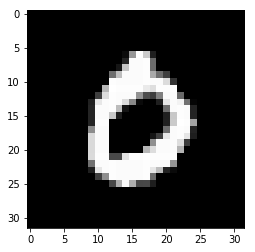

In [50]:
idx = int(input())

for i in range(0,32):

 ifMap = test_images[i].T.reshape(32, 32).tolist()

 C1 = model.conv(ifMap, np.array(weightList[0]).T.tolist(), weightList[1], 1, 1, 32, 5, 6)
 S2 = model.pool(C1, 2, 6, 28, 2)
 C3 = model.conv(S2, np.array(weightList[2]).T.tolist(), weightList[3], 1, 6, 14, 5, 16)
 S4 = model.pool(C3, 2, 16, 10, 2)
 C5 = model.conv(S4, np.array(weightList[4]).T.tolist(), weightList[5], 1, 16, 5, 5, 120)
 F6 = model.full(np.array(C5).reshape(120), weightList[6], weightList[7], 120, 84)
 ofMap = model.full(F6, weightList[8], weightList[9], 84, 10)

 print(f"예측: {np.argmax(ofMap)}, 정답: {test_labels[i]}")

pixels = test_images[idx].reshape(32, 32)
plt.imshow(pixels, cmap='gray')
plt.show()